In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.backends.backend_pdf
import pandas as pd

#plt.rcParams['figure.figsize'] = [40, 30]

In [2]:
def get_3D_Dose_dif(pred, gt, possible_dose_mask=None):
    if possible_dose_mask is not None:
        pred = pred[possible_dose_mask > 0]
        gt = gt[possible_dose_mask > 0]

    dif = np.mean(np.abs(pred - gt))
    return dif

def volumetric_dice(img, mask):
    img[img > 1] = 1
    img[img < 1] = 0
    mask[mask > 1] = 1
    mask[mask < 1] = 0
    return np.sum(mask[img == mask]) * 2.0 / (np.sum(img)+np.sum(mask))

In [3]:
########## Functions ###########
# function that calculates and plots the DVHs based on the dose array of a specific structure
def calc_dvhs (dose_array_gt, dose_array_pred, case_nr, name):
    bins = np.arange(0, np.ceil(np.max(dose_array_gt)), 0.1)
    total_voxels = len(dose_array_gt)
    values_gt = []
    values_pred = []
    for bin in bins:
        number_gt = (dose_array_gt >= bin).sum()
        number_pred = (dose_array_pred >= bin).sum()
        
        value_gt = number_gt/total_voxels * 100
        value_pred = number_pred/total_voxels * 100
        
        values_gt.append(value_gt)
        values_pred.append(value_pred)
        
    fig = plt.figure()
    plt.plot(bins, values_gt, color = "b", label = "ground truth")
    plt.plot(bins, values_pred, color = "r", label = "prediction")
    
    plt.xlabel('Dose [Gy]')
    plt.ylabel('Ratio of Total Structure Volume [%]')
    plt.title(case_nr + " " + name)
    plt.legend(loc='best')
    
    return(fig)

In [4]:
root_path = "/Users/amithkamath/repo/deep-planner"
data_path = os.path.join(root_path, "data", "processed-ONL")
pred_path = os.path.join(root_path, "data", "output-ONL", "output-ONL-6", "Prediction")
results_path = os.path.join(root_path, "results")

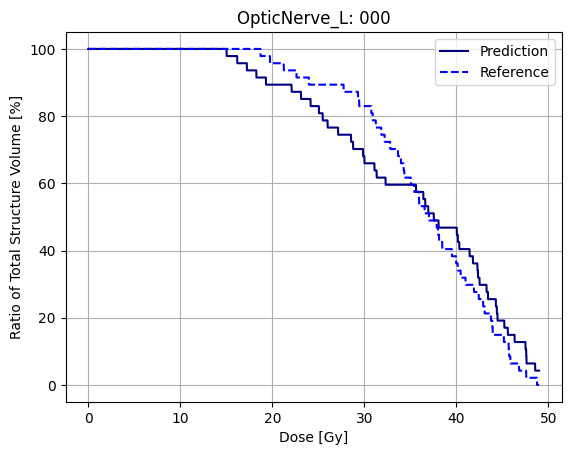

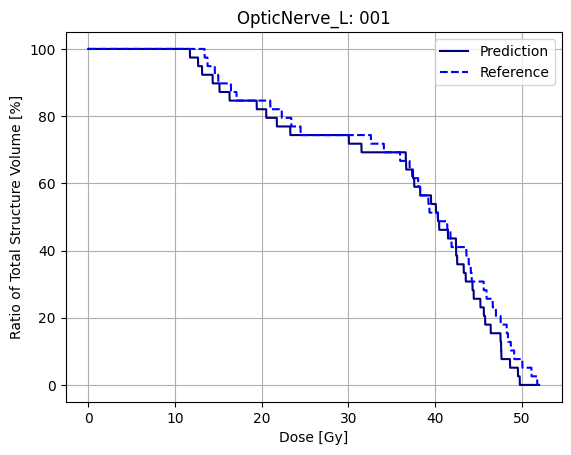

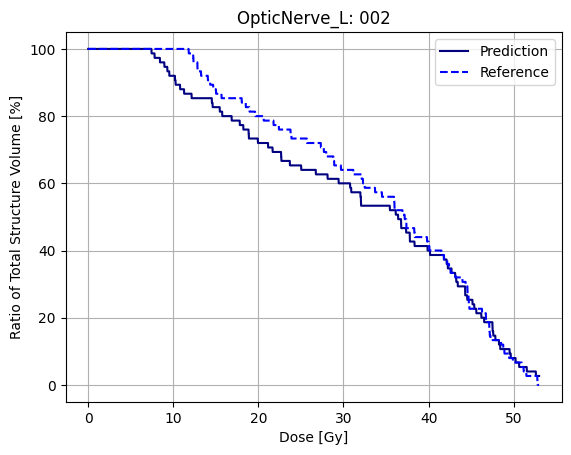

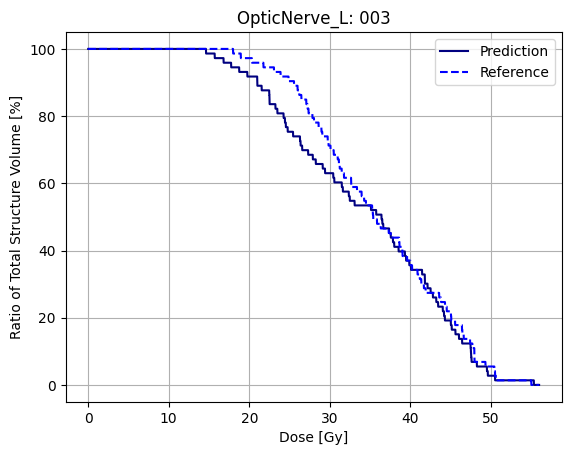

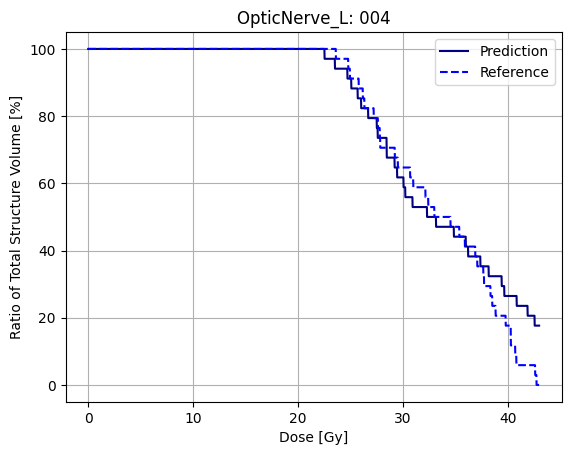

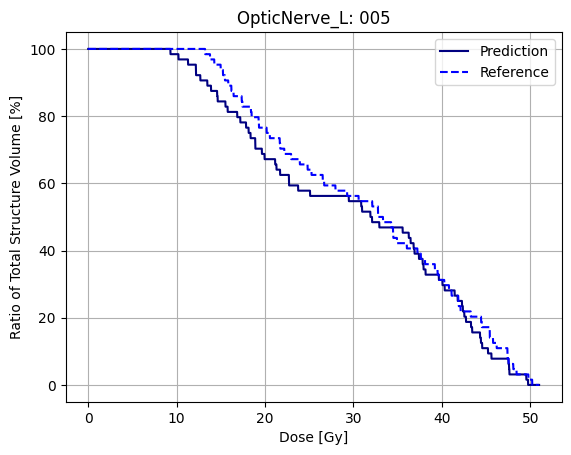

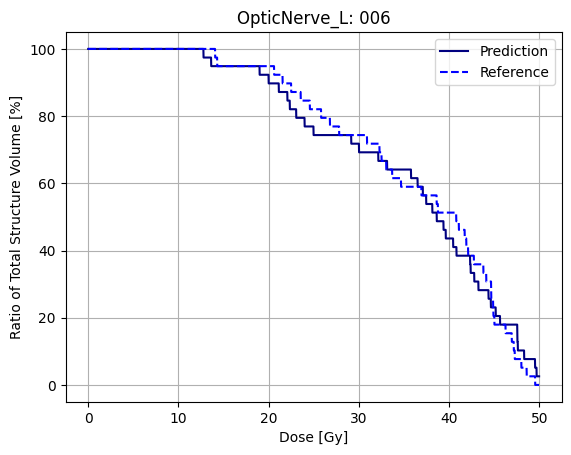

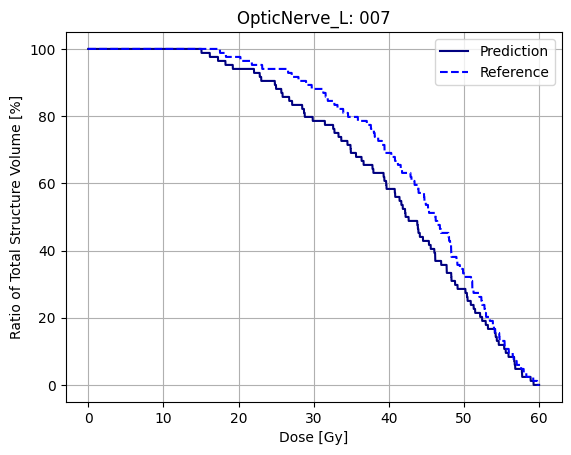

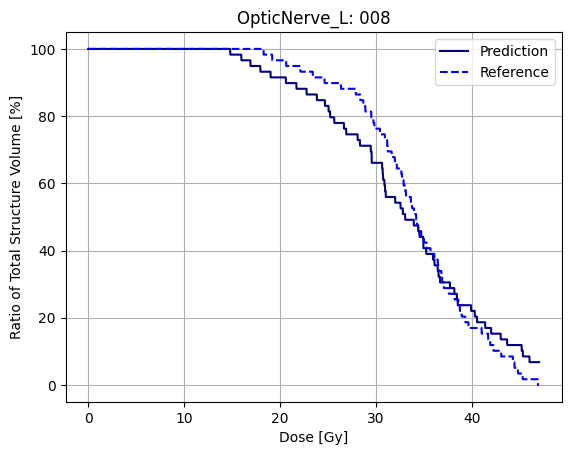

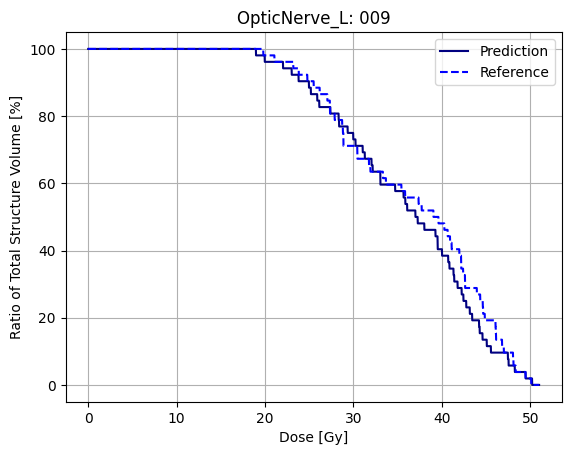

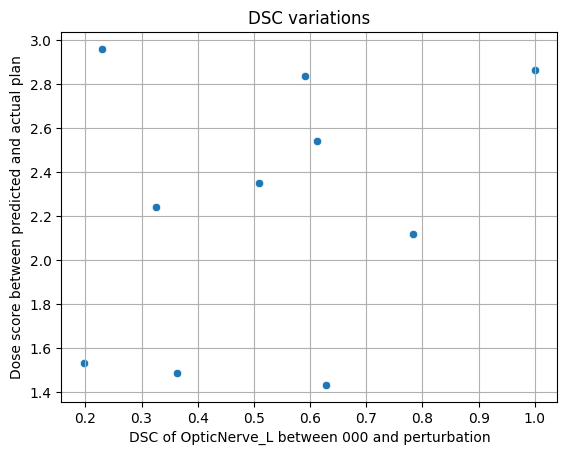

In [5]:
##########   Main   ############

# Output of this script is two dataframes containing all the dose metrics of the targets and oars.
# For each case a pdf file with the DVH curves of each structure comparing the ground truth vs the prediction 
# is constructed.

pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(results_path,"ONL-DVH-variations.pdf"))

# select all cases in the folder
cases = sorted(glob.glob(os.path.join(pred_path, "*")))

# define a list to store the dataframes for the dose metrics
frames_oars = []
frames_targets = []
case_names = []

# select the name of the structure
name = "OpticNerve_L"
base_structure = sitk.ReadImage(os.path.join(data_path, "DLDP_000", "OpticNerve_L.nii.gz"))
base_mask = sitk.GetArrayFromImage(base_structure)

dsc_list = []
dose_score_list = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    #if ("1" in case_nr) or ("3" in case_nr) or ("5" in case_nr) or ("7" in case_nr) or ("9" in case_nr):
    #    continue

    case_names.append(case_nr)
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)
    
    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)
    
    # select all the structures in the folder
    structure = os.path.join(data_path, case_nr) + "/OpticNerve_L.nii.gz"
    
    # define a list to store the dose metrics for the targets and oars
    oars = []
    targets = []
    
    # turn structure into a boolean mask
    struct = sitk.ReadImage(structure)
    mask = sitk.GetArrayFromImage(struct)
    mask = np.array(mask, dtype='bool')
    
    dsc = volumetric_dice(base_mask, mask)
    dsc_list.append(dsc)

    # Select all the dose values of the structures voxels
    dose_array_gt = np.array(dose_gt[mask])
    dose_array_pred = np.array(dose_pred[mask])
    
    dose_score = get_3D_Dose_dif(dose_pred, dose_gt, possible_dose_mask=mask)
    dose_score_list.append(dose_score)

    # perform OAR metrics
    max_dose_gt = np.max(dose_array_gt) 
    max_dose_pred = np.max(dose_array_pred)
    max_dose_1pct_gt = np.sort(dose_array_gt)[round(len(dose_array_gt)*0.99)-1]
    max_dose_1pct_gt = np.sort(dose_array_pred)[round(len(dose_array_pred)*0.99)-1]
    mean_dose_gt = np.mean(dose_array_gt)
    mean_dose_pred = np.mean(dose_array_pred)
    # safe all oar metrics in a list
    oars.append([name, max_dose_gt, max_dose_pred, max_dose_1pct_gt,
                    max_dose_1pct_gt, mean_dose_gt, mean_dose_pred])
    
    # calculate the DVHs
    bins = np.arange(0, np.ceil(np.max(dose_array_gt)), 0.01)
    total_voxels = len(dose_array_gt)
    values_gt = []
    values_pred = []
    for bin in bins:
        number_gt = (dose_array_gt >= bin).sum()
        number_pred = (dose_array_pred >= bin).sum()
        
        value_gt = number_gt/total_voxels * 100
        value_pred = number_pred/total_voxels * 100
        
        values_gt.append(value_gt)
        values_pred.append(value_pred)

    fig = plt.figure()
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, 10))))
    #plt.fill_between(bins, values_pred, values_gt, alpha=0.4)
    plt.plot(bins, values_pred, label="Prediction")
    plt.plot(bins, values_gt, '--', label="Reference")
    plt.gca().legend(loc='upper right')
    #plt.plot(bins, np.abs(np.array(values_pred) - np.array(values_gt)))
    
    # convert the lists containing the dose metrics into dataframes
    OARs_DF = pd.DataFrame(oars, columns = ["structure", "max_dose_gt", "max_dose_pred", "max_dose_1pct_gt",
                                            "max_dose_1pct_gt", "mean_dose_gt", "mean_dose_pred"])
    # save the dataframes of each case into a list
    frames_oars.append(OARs_DF)

    plt.xlabel('Dose [Gy]')
    plt.ylabel('Ratio of Total Structure Volume [%]')
    plt.title(name + ": " + case_nr[-3:])
    plt.grid()
    pdf.savefig(fig)
# concatenate all dataframes in a single dataframe and save as pickle file.
#OAR_metrics = pd.concat(frames_oars, keys = case_names)

fig = plt.figure()
sns.scatterplot(x=dsc_list, y = dose_score_list)
plt.xlabel('DSC of OpticNerve_L between 000 and perturbation')
plt.ylabel('Dose score between predicted and actual plan')
plt.title("DSC variations")
plt.grid()

pdf.savefig(fig)
pdf.close()

In [6]:
# select all cases in the folder
cases = sorted(glob.glob(os.path.join(pred_path,"*")))

# define a list to store the dataframes for the dose metrics
dose_diff_data = {}
dose_mean_data = {}
pred_mean_data = {}
case_names = []

for case in cases:
    # select the case number
    case_nr = case.split("/")[-1]
    case_names.append(case_nr)
    
    # select and read the ground truth dose
    dose_gt_path = glob.glob(os.path.join(data_path, case_nr) + "/Dose.nii.gz")
    dose_gt = sitk.ReadImage(dose_gt_path[0])
    dose_gt = sitk.GetArrayFromImage(dose_gt)

    # select and read the predicted dose
    dose_pred_path = glob.glob(os.path.join(pred_path, case_nr) + "/Dose.nii.gz")
    dose_pred = sitk.ReadImage(dose_pred_path[0])
    dose_pred = sitk.GetArrayFromImage(dose_pred)

    # select all the structures in the folder
    structures = glob.glob(os.path.join(data_path, case_nr) + "/[!Dose]*")

    # define a list to store the dose metrics for the targets and oars
    dose_diff = {}
    dose_mean = {}
    pred_mean = {}
    names = []

    # For every structure calculate the DVHs and dose metrics
    for structure in structures:
        # select the name of the structure
        name = structure.split("/")[-1].split(".")[0]

        # If CT, ignore
        if name == "CT":
            continue
        
        # turn structure into a boolean mask
        struct = sitk.ReadImage(structure)
        mask = sitk.GetArrayFromImage(struct)
        mask = np.array(mask, dtype='bool')

        diff = get_3D_Dose_dif(dose_pred, dose_gt, possible_dose_mask=mask)
        mean_gt = np.mean(dose_gt[mask > 0])
        mean_pred = np.mean(dose_pred[mask > 0])

        # then compute the percentage of difference to the mean GT, and store in dict.
        dose_diff[name] = diff
        dose_mean[name] = mean_gt
        pred_mean[name] = mean_pred
        names.append(name)

    #subject_data = pd.DataFrame.from_dict(dose_percent, orient='index',
    #                   columns=names)
    dose_diff_data[case_nr] = dose_diff
    dose_mean_data[case_nr] = dose_mean
    pred_mean_data[case_nr] = pred_mean

subject_data = pd.DataFrame.from_dict(dose_diff_data)
subject_data.to_csv(os.path.join(root_path, "results", "ONL_mean_difference.csv"))

subject_data = pd.DataFrame.from_dict(dose_mean_data)
subject_data.to_csv(os.path.join(root_path, "results", "ONL_mean_gt_dose.csv"))

subject_data = pd.DataFrame.from_dict(pred_mean_data)
subject_data.to_csv(os.path.join(root_path, "results", "ONL_mean_pred_dose.csv"))